# Практическое задание по занятию Denosing Diffusional Models

## Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (2 балла)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


In [1]:
!git clone https://github.com/awjuliani/pytorch-diffusion.git
!mv pytorch-diffusion/* .

Cloning into 'pytorch-diffusion'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 15), reused 29 (delta 10), pack-reused 0
Receiving objects: 100% (35/35), 1.48 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob

### Set model parameters

In [3]:
# Training hyperparameters
diffusion_steps = 1000
# dataset_choice = "CIFAR"
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

### Load dataset and train model

In [4]:
# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [5]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

100%|██████████| 26421880/26421880 [00:27<00:00, 956057.75it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 112032.99it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2117469.81it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9060963.91it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Определим свой логгер

In [6]:
class ConsoleLogger(pl.loggers.TensorBoardLogger):
    def __init__(self, *args, **kwargs):
        super(ConsoleLogger, self).__init__(*args, **kwargs)
        self.logs = []

    def log_metrics(self, metrics, step):
        print(f"Step {step}, Metrics: {metrics}")        
        self.logs.append((step, metrics))

    def finalize(self, status):
        for step, metrics in self.logs:
            print(f"Step {step}, Metrics: {metrics}")

In [7]:
# logger = pl.loggers.TensorBoardLogger(
#     "lightning_logs/",
#     name=dataset_choice,
#     version=pass_version,
# )

logger = ConsoleLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=100,
    # gpus=1, 
    # auto_select_gpus=True,
    # resume_from_checkpoint=last_checkpoint, 
    logger=logger
)

# Train model

In [ ]:
# !rm -r /kaggle/working/lightning_logs/Fashion/

In [ ]:
trainer.fit(model, train_loader, val_loader)

## Посмотрим насколько вообще хорошо модель справляется с кодированием - декодированием

In [ ]:
sample_batch_size = next(iter(train_loader))

sample_steps = torch.arange(model.t_range - 1, 0, -1)
t = sample_steps[0]

output = model(sample_batch_size, t).moveaxis(1, 3).squeeze(-1)
orig = sample_batch_size.moveaxis(1, 3).squeeze(-1)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для создания сетки графиков
def plot_images(images, gif_shape):
    fig, axs = plt.subplots(*gif_shape, figsize=(12, 12))
    
    for i in range(gif_shape[0]):
        for j in range(gif_shape[1]):
            idx = i * gif_shape[1] + j
            axs[i, j].imshow(images[idx])
            axs[i, j].axis("off")
            axs[i, j].set_title(f"Step {idx}")

    plt.show()


# Преобразование тензора в массив изображений
def tensor_to_images(tensor):
    return tensor.detach().cpu().numpy()


def plot_original_vs_processed(originals, processed, in_line):
    if in_line % 2 != 0:
        raise ValueError("in_line must be even number")
        
    gif_shape = [in_line, in_line]
    fig, axs = plt.subplots(*gif_shape, figsize=(12, 12))

    for i in range(0, gif_shape[0], 2):
        for j in range(0, gif_shape[1]):
            # Вывести оригинальное изображение
            axs[i, j].imshow(originals[i + j])
            axs[i, j].axis("off")
            axs[i, j].set_title(f"Original {i + j}")

            # Вывести обработанное изображение
            axs[i + 1, j].imshow(processed[i + j])
            axs[i + 1, j].axis("off")
            axs[i + 1, j].set_title(f"Processed {i + j}")

    plt.show()

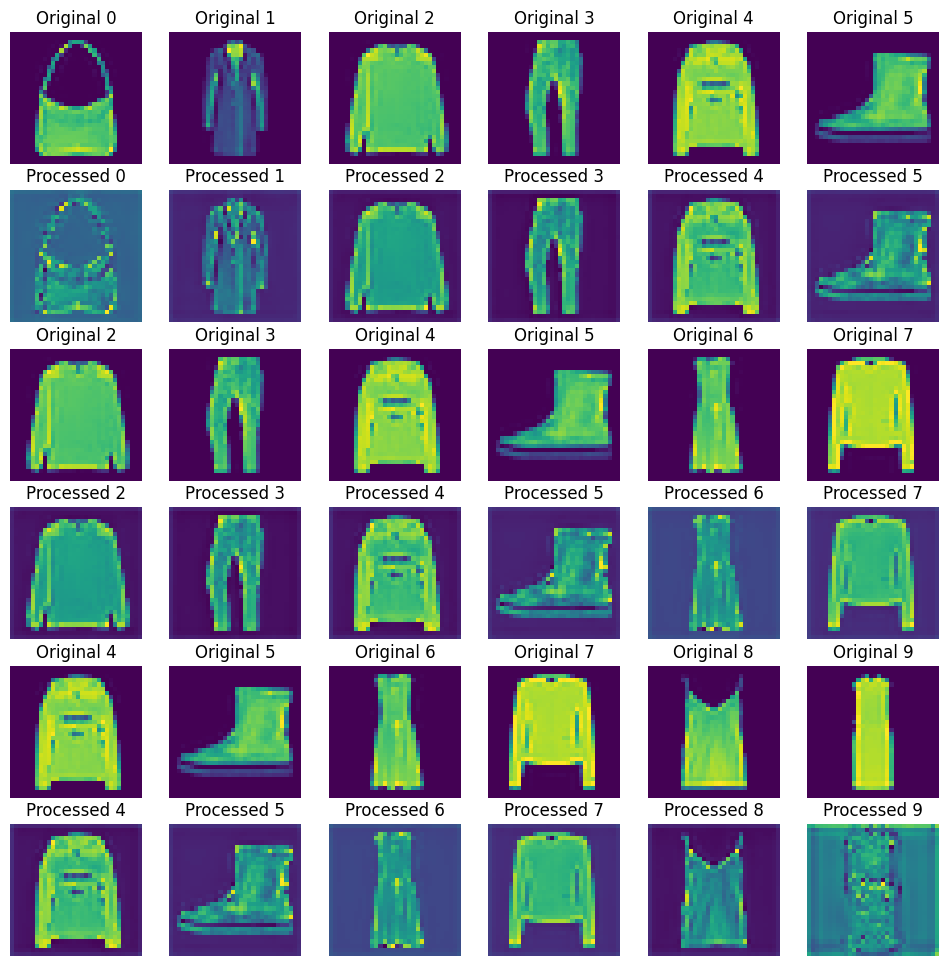

In [34]:
# Преобразовать тензоры в массивы изображений
orig_images = tensor_to_images(orig)
output_images = tensor_to_images(output)

# Использовать функцию для создания графика
plot_original_vs_processed(orig_images, output_images, in_line=6)

### Цвета совсем другие, но в целом некоторые фото на мой взгляд модель делает лучше

## А теперь из шума сгенерим что-то

In [35]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10

# Generate samples from denoising process
gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
# gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

In [ ]:
tensor_to_images(gen_samples).shape

In [9]:
def plot_all_images(output, row, columns):
    fig, axs = plt.subplots(row, columns, figsize=(12, 12))

    for i in range(row):
        for j in range(columns):
            idx = i * columns + j
            axs[i, j].imshow(output[i][j])
            axs[i, j].axis("off")
            axs[i, j].set_title(f"Step {i}")

    plt.show()


## Результат после 30 эпох

In [ ]:
# Отобразим срез после 10
plot_all_images(tensor_to_images(gen_samples[10:]), row=10, columns=9)
# plot_all_images(tensor_to_images(gen_samples), row=gen_samples.size(0), columns=gen_samples.size(1))
# plot_images(tensor_to_images(gen_samples), [, 32])

In [ ]:
gen_samples_stacked.shape

In [ ]:
import imageio
import numpy as np

# Преобразовать значения в диапазон от 0 до 255
gen_samples = (gen_samples * 255).type(torch.uint8)

# Преобразовать Tensor в массив NumPy
gen_samples_np = gen_samples.numpy()

# Стекание по последней размерности
gen_samples_stacked = np.concatenate(gen_samples_np, axis=-1)

# Сохранение gif
imageio.mimsave(
    f"{trainer.logger.log_dir}/pred.gif",
    gen_samples_stacked,
    duration=0.05
)


## Гифка после 10 эпох

<img src="lightning_logs/Fashion/version_5/pred.gif" autoplay>
<a href="lightning_logs/Fashion/version_5/pred.gif" download>Открыть гифку</a>

## Гифка после 30 эпох (Изменил формат)

<img src="lightning_logs/Fashion/version_6/pred.gif" autoplay>
<a href="lightning_logs/Fashion/version_6/pred.gif" download>Открыть гифку</a>

In [ ]:
# Выполняем этот код, если компануем по 9 штук на одной картинке
# Process samples and save as gif
gen_samples_block = (gen_samples * 255).type(torch.uint8)
gen_samples_block = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples_block = stack_samples(gen_samples_block, 2)
gen_samples_block = stack_samples(gen_samples_block, 2)

In [ ]:
def plot_stack_images(output, row, columns):
    fig, axs = plt.subplots(row, columns, figsize=(12, 12))

    for i in range(row):
        for j in range(columns):
            idx = i * columns + j
            axs[i, j].imshow(output[idx])
            axs[i, j].axis("off")
            axs[i, j].set_title(f"Image {idx}")

    plt.show()

plot_stack_images(tensor_to_images(gen_samples_block), 4, 7)

### Как видим, получилось проявить картинку

## CFG

In [10]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms


class DiffSet(Dataset):
    def __init__(self, train, dataset="MNIST"):
        transform = transforms.Compose([transforms.ToTensor()])

        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train, transform=transform
        )

        self.dataset_len = len(train_dataset.data)

        if dataset == "MNIST" or dataset == "Fashion":
            pad = transforms.Pad(2)
            data = pad(train_dataset.data)
            data = data.unsqueeze(3)
            self.depth = 1
            self.size = 32
        elif dataset == "CIFAR":
            data = torch.Tensor(train_dataset.data)
            self.depth = 3
            self.size = 32
        self.input_seq = ((data / 255.0) * 2.0) - 1.0
        self.input_seq = self.input_seq.moveaxis(3, 1)

        self.labels = train_dataset.targets

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
        return self.input_seq[item], self.labels[item]


In [22]:
inputs, labels = next(iter(train_loader))

In [23]:
inputs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

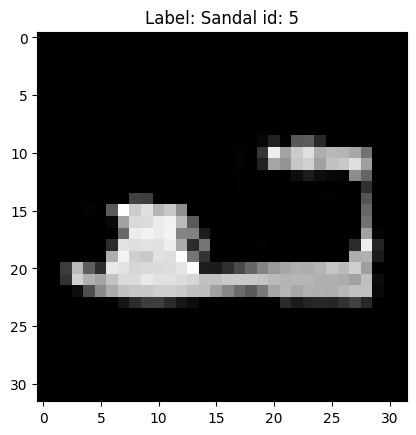

In [24]:
import matplotlib.pyplot as plt
import torchvision

# Выводим первое изображение из батча
image = torchvision.utils.make_grid(inputs[0], normalize=True)
label = labels[0].item()

# matplotlib имеет функцию imshow для вывода изображений
plt.imshow(image.permute(1, 2, 0))
plt.title(f'Label: {class_names[label]} id: {label}')
plt.show()

In [11]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import math
from modules import *


class DiffusionCFGModel(pl.LightningModule):
    def __init__(self, in_size, t_range, img_depth, num_classes=None):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.in_size = in_size

        bilinear = True
        self.inc = DoubleConv(img_depth, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, img_depth)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

        if num_classes is not None:
            print(f"T RANGE {t_range}")
            self.label_emb = nn.Embedding(num_classes, 1)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t, labels=None):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        if labels is not None:
            # Или попробовать после self.pos_encoding
            t += self.label_emb(labels) 
#             label_emb = self.label_emb(labels).long().to(self.device)
#             t = t.to(self.device) + label_emb

        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)

        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (
            self.beta_large - self.beta_small
        )

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        t_range = int(t)
        return math.prod([self.alpha(j) for j in range(t_range)])

    def get_loss(self, batch, batch_idx):
        """
        Corresponds to Algorithm 1 from (Ho et al., 2020).
        """
        inputs, labels = batch

        ts = torch.randint(0, self.t_range, [inputs.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(inputs.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * inputs[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float), labels)
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss

    def denoise_sample(self, x, t, labels=None):
        """
        Corresponds to the inner loop of Algorithm 2 from (Ho et al., 2020).
        """
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape)
            else:
                z = 0
                
            e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1), labels)
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer


In [12]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_classes = len(class_names) 

In [13]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionCFGModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth, num_classes=num_classes)
else:
    model = DiffusionCFGModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth, num_classes)

T RANGE 1000


In [28]:
trainer = pl.Trainer(
#     max_epochs=max_epoch, 
    max_epochs=30, 
    log_every_n_steps=100,
    logger=logger
)

In [29]:
trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory lightning_logs/Fashion/version_0/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Step 99, Metrics: {'train/loss': 0.04900817573070526, 'epoch': 0}
Step 199, Metrics: {'train/loss': 0.062426649034023285, 'epoch': 0}
Step 299, Metrics: {'train/loss': 0.04428495839238167, 'epoch': 0}
Step 399, Metrics: {'train/loss': 0.044242218136787415, 'epoch': 0}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 468, Metrics: {'val/loss': 0.04585130512714386, 'epoch': 0}
Step 499, Metrics: {'train/loss': 0.03708580881357193, 'epoch': 1}
Step 599, Metrics: {'train/loss': 0.0619342178106308, 'epoch': 1}
Step 699, Metrics: {'train/loss': 0.047660812735557556, 'epoch': 1}
Step 799, Metrics: {'train/loss': 0.04880573973059654, 'epoch': 1}
Step 899, Metrics: {'train/loss': 0.04074861481785774, 'epoch': 1}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 937, Metrics: {'val/loss': 0.04904841631650925, 'epoch': 1}
Step 999, Metrics: {'train/loss': 0.04241030663251877, 'epoch': 2}
Step 1099, Metrics: {'train/loss': 0.031722571700811386, 'epoch': 2}
Step 1199, Metrics: {'train/loss': 0.03746907413005829, 'epoch': 2}
Step 1299, Metrics: {'train/loss': 0.037997618317604065, 'epoch': 2}
Step 1399, Metrics: {'train/loss': 0.037899769842624664, 'epoch': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 1406, Metrics: {'val/loss': 0.039458032697439194, 'epoch': 2}
Step 1499, Metrics: {'train/loss': 0.03807412460446358, 'epoch': 3}
Step 1599, Metrics: {'train/loss': 0.05336933583021164, 'epoch': 3}
Step 1699, Metrics: {'train/loss': 0.047723688185214996, 'epoch': 3}
Step 1799, Metrics: {'train/loss': 0.035188108682632446, 'epoch': 3}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 1875, Metrics: {'val/loss': 0.039797764271497726, 'epoch': 3}
Step 1899, Metrics: {'train/loss': 0.03347427770495415, 'epoch': 4}
Step 1999, Metrics: {'train/loss': 0.03817560523748398, 'epoch': 4}
Step 2099, Metrics: {'train/loss': 0.034295160323381424, 'epoch': 4}
Step 2199, Metrics: {'train/loss': 0.03502791374921799, 'epoch': 4}
Step 2299, Metrics: {'train/loss': 0.03697395324707031, 'epoch': 4}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 2344, Metrics: {'val/loss': 0.038041722029447556, 'epoch': 4}
Step 2399, Metrics: {'train/loss': 0.0303525160998106, 'epoch': 5}
Step 2499, Metrics: {'train/loss': 0.037577223032712936, 'epoch': 5}
Step 2599, Metrics: {'train/loss': 0.03890328109264374, 'epoch': 5}
Step 2699, Metrics: {'train/loss': 0.03544149175286293, 'epoch': 5}
Step 2799, Metrics: {'train/loss': 0.0386098250746727, 'epoch': 5}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 2813, Metrics: {'val/loss': 0.03590289130806923, 'epoch': 5}
Step 2899, Metrics: {'train/loss': 0.03865716606378555, 'epoch': 6}
Step 2999, Metrics: {'train/loss': 0.030501170083880424, 'epoch': 6}
Step 3099, Metrics: {'train/loss': 0.03725285083055496, 'epoch': 6}
Step 3199, Metrics: {'train/loss': 0.04278016462922096, 'epoch': 6}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 3282, Metrics: {'val/loss': 0.03568840026855469, 'epoch': 6}
Step 3299, Metrics: {'train/loss': 0.038653988391160965, 'epoch': 7}
Step 3399, Metrics: {'train/loss': 0.033775024116039276, 'epoch': 7}
Step 3499, Metrics: {'train/loss': 0.02953270450234413, 'epoch': 7}
Step 3599, Metrics: {'train/loss': 0.036421339958906174, 'epoch': 7}
Step 3699, Metrics: {'train/loss': 0.04664680361747742, 'epoch': 7}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 3751, Metrics: {'val/loss': 0.03437655419111252, 'epoch': 7}
Step 3799, Metrics: {'train/loss': 0.02966994047164917, 'epoch': 8}
Step 3899, Metrics: {'train/loss': 0.021285973489284515, 'epoch': 8}
Step 3999, Metrics: {'train/loss': 0.02869863063097, 'epoch': 8}
Step 4099, Metrics: {'train/loss': 0.025220492854714394, 'epoch': 8}
Step 4199, Metrics: {'train/loss': 0.030131317675113678, 'epoch': 8}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 4220, Metrics: {'val/loss': 0.033885810524225235, 'epoch': 8}
Step 4299, Metrics: {'train/loss': 0.04294624924659729, 'epoch': 9}
Step 4399, Metrics: {'train/loss': 0.03614401817321777, 'epoch': 9}
Step 4499, Metrics: {'train/loss': 0.03628433123230934, 'epoch': 9}
Step 4599, Metrics: {'train/loss': 0.04111146926879883, 'epoch': 9}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 4689, Metrics: {'val/loss': 0.03455466404557228, 'epoch': 9}
Step 4699, Metrics: {'train/loss': 0.04106539487838745, 'epoch': 10}
Step 4799, Metrics: {'train/loss': 0.034914273768663406, 'epoch': 10}
Step 4899, Metrics: {'train/loss': 0.028829585760831833, 'epoch': 10}
Step 4999, Metrics: {'train/loss': 0.034856319427490234, 'epoch': 10}
Step 5099, Metrics: {'train/loss': 0.03555954247713089, 'epoch': 10}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 5158, Metrics: {'val/loss': 0.03295808285474777, 'epoch': 10}
Step 5199, Metrics: {'train/loss': 0.02652045711874962, 'epoch': 11}
Step 5299, Metrics: {'train/loss': 0.03198545426130295, 'epoch': 11}
Step 5399, Metrics: {'train/loss': 0.036435723304748535, 'epoch': 11}
Step 5499, Metrics: {'train/loss': 0.03669290617108345, 'epoch': 11}
Step 5599, Metrics: {'train/loss': 0.023790372535586357, 'epoch': 11}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 5627, Metrics: {'val/loss': 0.03357872739434242, 'epoch': 11}
Step 5699, Metrics: {'train/loss': 0.03405441343784332, 'epoch': 12}
Step 5799, Metrics: {'train/loss': 0.02922208048403263, 'epoch': 12}
Step 5899, Metrics: {'train/loss': 0.028397206217050552, 'epoch': 12}
Step 5999, Metrics: {'train/loss': 0.037107400596141815, 'epoch': 12}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 6096, Metrics: {'val/loss': 0.03317740932106972, 'epoch': 12}
Step 6099, Metrics: {'train/loss': 0.025882814079523087, 'epoch': 13}
Step 6199, Metrics: {'train/loss': 0.03800899162888527, 'epoch': 13}
Step 6299, Metrics: {'train/loss': 0.024763934314250946, 'epoch': 13}
Step 6399, Metrics: {'train/loss': 0.04105061665177345, 'epoch': 13}
Step 6499, Metrics: {'train/loss': 0.04201541095972061, 'epoch': 13}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 6565, Metrics: {'val/loss': 0.033108189702034, 'epoch': 13}
Step 6599, Metrics: {'train/loss': 0.034940749406814575, 'epoch': 14}
Step 6699, Metrics: {'train/loss': 0.03914777562022209, 'epoch': 14}
Step 6799, Metrics: {'train/loss': 0.028696075081825256, 'epoch': 14}
Step 6899, Metrics: {'train/loss': 0.034375034272670746, 'epoch': 14}
Step 6999, Metrics: {'train/loss': 0.03318187594413757, 'epoch': 14}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 7034, Metrics: {'val/loss': 0.03185742348432541, 'epoch': 14}
Step 7099, Metrics: {'train/loss': 0.02980833873152733, 'epoch': 15}
Step 7199, Metrics: {'train/loss': 0.025460664182901382, 'epoch': 15}
Step 7299, Metrics: {'train/loss': 0.04441017657518387, 'epoch': 15}
Step 7399, Metrics: {'train/loss': 0.024747848510742188, 'epoch': 15}
Step 7499, Metrics: {'train/loss': 0.03480832278728485, 'epoch': 15}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 7503, Metrics: {'val/loss': 0.033416010439395905, 'epoch': 15}
Step 7599, Metrics: {'train/loss': 0.034976527094841, 'epoch': 16}
Step 7699, Metrics: {'train/loss': 0.034159786999225616, 'epoch': 16}
Step 7799, Metrics: {'train/loss': 0.027789579704403877, 'epoch': 16}
Step 7899, Metrics: {'train/loss': 0.026646146550774574, 'epoch': 16}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 7972, Metrics: {'val/loss': 0.033229295164346695, 'epoch': 16}
Step 7999, Metrics: {'train/loss': 0.035122647881507874, 'epoch': 17}
Step 8099, Metrics: {'train/loss': 0.03168433904647827, 'epoch': 17}
Step 8199, Metrics: {'train/loss': 0.03879627585411072, 'epoch': 17}
Step 8299, Metrics: {'train/loss': 0.027650438249111176, 'epoch': 17}
Step 8399, Metrics: {'train/loss': 0.03239627927541733, 'epoch': 17}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 8441, Metrics: {'val/loss': 0.03319447115063667, 'epoch': 17}
Step 8499, Metrics: {'train/loss': 0.03171302378177643, 'epoch': 18}
Step 8599, Metrics: {'train/loss': 0.03172799199819565, 'epoch': 18}
Step 8699, Metrics: {'train/loss': 0.026824140921235085, 'epoch': 18}
Step 8799, Metrics: {'train/loss': 0.03636486083269119, 'epoch': 18}
Step 8899, Metrics: {'train/loss': 0.02636699564754963, 'epoch': 18}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 8910, Metrics: {'val/loss': 0.03128884732723236, 'epoch': 18}
Step 8999, Metrics: {'train/loss': 0.02724641188979149, 'epoch': 19}
Step 9099, Metrics: {'train/loss': 0.022652961313724518, 'epoch': 19}
Step 9199, Metrics: {'train/loss': 0.026150144636631012, 'epoch': 19}
Step 9299, Metrics: {'train/loss': 0.029733901843428612, 'epoch': 19}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 9379, Metrics: {'val/loss': 0.031645894050598145, 'epoch': 19}
Step 9399, Metrics: {'train/loss': 0.027203554287552834, 'epoch': 20}
Step 9499, Metrics: {'train/loss': 0.03580426424741745, 'epoch': 20}
Step 9599, Metrics: {'train/loss': 0.03275304660201073, 'epoch': 20}
Step 9699, Metrics: {'train/loss': 0.030555754899978638, 'epoch': 20}
Step 9799, Metrics: {'train/loss': 0.03125246614217758, 'epoch': 20}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 9848, Metrics: {'val/loss': 0.03228489309549332, 'epoch': 20}
Step 9899, Metrics: {'train/loss': 0.0317804180085659, 'epoch': 21}
Step 9999, Metrics: {'train/loss': 0.02832527458667755, 'epoch': 21}
Step 10099, Metrics: {'train/loss': 0.02836882509291172, 'epoch': 21}
Step 10199, Metrics: {'train/loss': 0.02977699413895607, 'epoch': 21}
Step 10299, Metrics: {'train/loss': 0.03589523583650589, 'epoch': 21}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 10317, Metrics: {'val/loss': 0.03259234130382538, 'epoch': 21}
Step 10399, Metrics: {'train/loss': 0.03805895522236824, 'epoch': 22}
Step 10499, Metrics: {'train/loss': 0.03468985855579376, 'epoch': 22}
Step 10599, Metrics: {'train/loss': 0.03342903405427933, 'epoch': 22}
Step 10699, Metrics: {'train/loss': 0.03732074424624443, 'epoch': 22}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 10786, Metrics: {'val/loss': 0.03097999282181263, 'epoch': 22}
Step 10799, Metrics: {'train/loss': 0.034128155559301376, 'epoch': 23}
Step 10899, Metrics: {'train/loss': 0.033081140369176865, 'epoch': 23}
Step 10999, Metrics: {'train/loss': 0.023753035813570023, 'epoch': 23}
Step 11099, Metrics: {'train/loss': 0.03577738255262375, 'epoch': 23}
Step 11199, Metrics: {'train/loss': 0.02753370814025402, 'epoch': 23}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 11255, Metrics: {'val/loss': 0.030706210061907768, 'epoch': 23}
Step 11299, Metrics: {'train/loss': 0.030117925256490707, 'epoch': 24}
Step 11399, Metrics: {'train/loss': 0.03195462003350258, 'epoch': 24}
Step 11499, Metrics: {'train/loss': 0.02879968285560608, 'epoch': 24}
Step 11599, Metrics: {'train/loss': 0.03286312520503998, 'epoch': 24}
Step 11699, Metrics: {'train/loss': 0.03166791424155235, 'epoch': 24}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 11724, Metrics: {'val/loss': 0.031056003645062447, 'epoch': 24}
Step 11799, Metrics: {'train/loss': 0.032653458416461945, 'epoch': 25}
Step 11899, Metrics: {'train/loss': 0.026452846825122833, 'epoch': 25}
Step 11999, Metrics: {'train/loss': 0.03722788766026497, 'epoch': 25}
Step 12099, Metrics: {'train/loss': 0.03336958959698677, 'epoch': 25}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 12193, Metrics: {'val/loss': 0.031234100461006165, 'epoch': 25}
Step 12199, Metrics: {'train/loss': 0.025321975350379944, 'epoch': 26}
Step 12299, Metrics: {'train/loss': 0.029776111245155334, 'epoch': 26}
Step 12399, Metrics: {'train/loss': 0.02538163959980011, 'epoch': 26}
Step 12499, Metrics: {'train/loss': 0.025705678388476372, 'epoch': 26}
Step 12599, Metrics: {'train/loss': 0.0359729640185833, 'epoch': 26}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 12662, Metrics: {'val/loss': 0.031030837446451187, 'epoch': 26}
Step 12699, Metrics: {'train/loss': 0.031174592673778534, 'epoch': 27}
Step 12799, Metrics: {'train/loss': 0.030345773324370384, 'epoch': 27}
Step 12899, Metrics: {'train/loss': 0.03273452818393707, 'epoch': 27}
Step 12999, Metrics: {'train/loss': 0.034755244851112366, 'epoch': 27}
Step 13099, Metrics: {'train/loss': 0.036570001393556595, 'epoch': 27}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 13131, Metrics: {'val/loss': 0.03181953728199005, 'epoch': 27}
Step 13199, Metrics: {'train/loss': 0.03712298721075058, 'epoch': 28}
Step 13299, Metrics: {'train/loss': 0.03297073021531105, 'epoch': 28}
Step 13399, Metrics: {'train/loss': 0.03383626043796539, 'epoch': 28}
Step 13499, Metrics: {'train/loss': 0.028206704184412956, 'epoch': 28}
Step 13599, Metrics: {'train/loss': 0.026523210108280182, 'epoch': 28}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 13600, Metrics: {'val/loss': 0.031211715191602707, 'epoch': 28}
Step 13699, Metrics: {'train/loss': 0.03353741765022278, 'epoch': 29}
Step 13799, Metrics: {'train/loss': 0.030071353539824486, 'epoch': 29}
Step 13899, Metrics: {'train/loss': 0.0224886704236269, 'epoch': 29}
Step 13999, Metrics: {'train/loss': 0.034463971853256226, 'epoch': 29}


Validation: |          | 0/? [00:00<?, ?it/s]

Step 14069, Metrics: {'val/loss': 0.030664676800370216, 'epoch': 29}
Step 99, Metrics: {'train/loss': 0.08658776432275772, 'epoch': 0}
Step 199, Metrics: {'train/loss': 0.06387528777122498, 'epoch': 0}
Step 299, Metrics: {'train/loss': 0.05303763598203659, 'epoch': 0}
Step 399, Metrics: {'train/loss': 0.06711983680725098, 'epoch': 0}
Step 468, Metrics: {'val/loss': 0.05081304535269737, 'epoch': 0}
Step 99, Metrics: {'train/loss': 0.04900817573070526, 'epoch': 0}
Step 199, Metrics: {'train/loss': 0.062426649034023285, 'epoch': 0}
Step 299, Metrics: {'train/loss': 0.04428495839238167, 'epoch': 0}
Step 399, Metrics: {'train/loss': 0.044242218136787415, 'epoch': 0}
Step 468, Metrics: {'val/loss': 0.04585130512714386, 'epoch': 0}
Step 499, Metrics: {'train/loss': 0.03708580881357193, 'epoch': 1}
Step 599, Metrics: {'train/loss': 0.0619342178106308, 'epoch': 1}
Step 699, Metrics: {'train/loss': 0.047660812735557556, 'epoch': 1}
Step 799, Metrics: {'train/loss': 0.04880573973059654, 'epoch': 

## Кодирование - декодирование

In [ ]:
# t.unsqueeze(0).repeat(128, 1).shape
t.shape

In [30]:
inputs, labels = next(iter(train_loader))

t = torch.randint(0, model.t_range, (inputs.size(0), 1), device=model.device, dtype=torch.float)

output = model(inputs, t, labels).moveaxis(1, 3).squeeze(-1)
orig = inputs.moveaxis(1, 3).squeeze(-1)

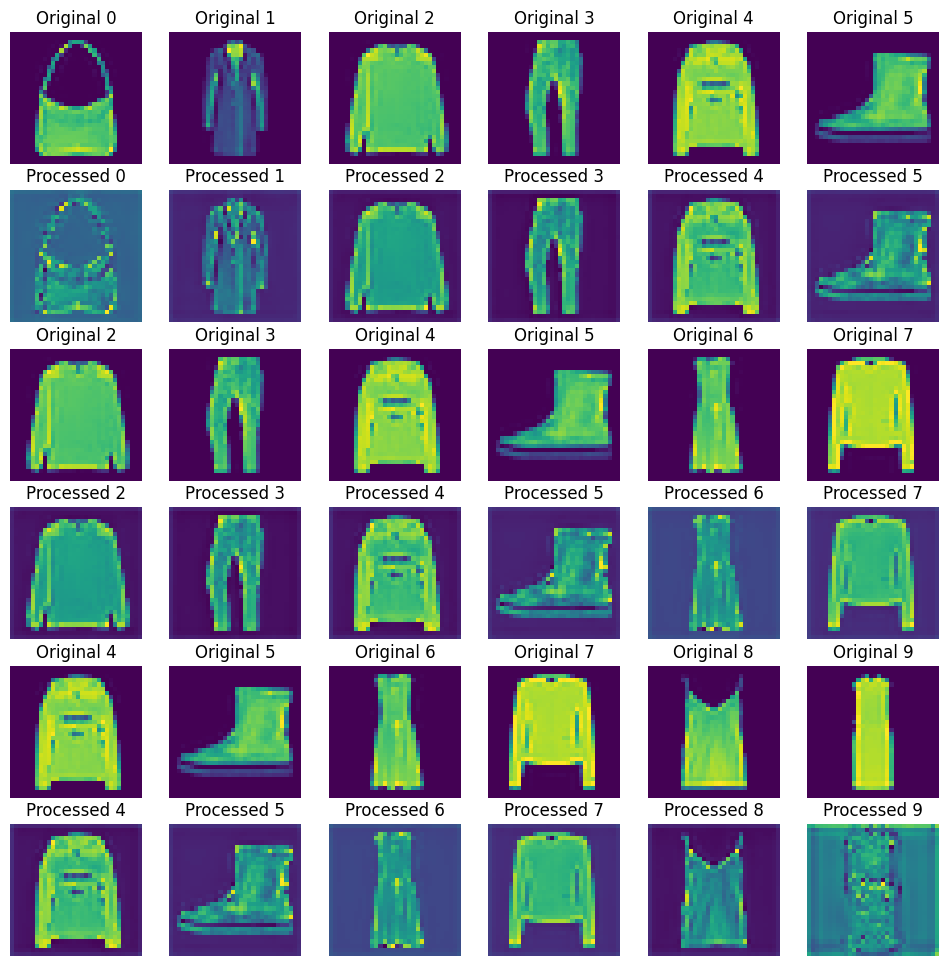

In [31]:
# Преобразовать тензоры в массивы изображений
orig_images = tensor_to_images(orig)
output_images = tensor_to_images(output)

# График
plot_original_vs_processed(orig_images, output_images, in_line=6)

## Генерация из шума

## Без меток

In [ ]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10

# Generate samples from denoising process
gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
# gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

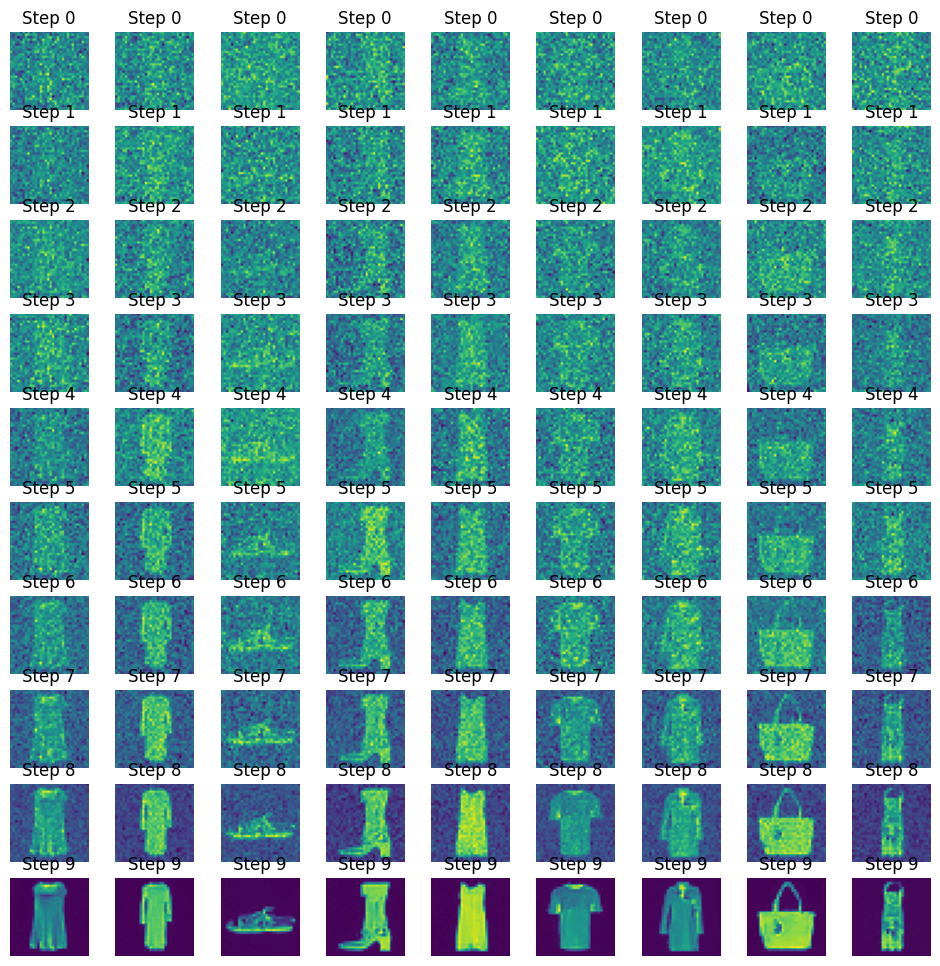

In [36]:
# Отобразим срез после 10
plot_all_images(tensor_to_images(gen_samples[10:]), row=10, columns=9)

## С метками

In [32]:
import torch

gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10

sample_label = torch.randint(0, num_classes, (sample_batch_size,), device=model.device)
# sample_label = torch.randint(0, 1, (sample_batch_size,), device=model.device)

gen_cond_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range - 1, 0, -1)

for t in sample_steps:
    t = t.type(torch.float)
#     t.to(model.device)
    
    x = model.denoise_sample(x, t, sample_label)
    
    if t % 50 == 0:
        gen_cond_samples.append(x)

for _ in range(n_hold_final):
    gen_cond_samples.append(x)

gen_cond_samples = torch.stack(gen_cond_samples, dim=0).moveaxis(2, 4).squeeze(-1)


['T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top']


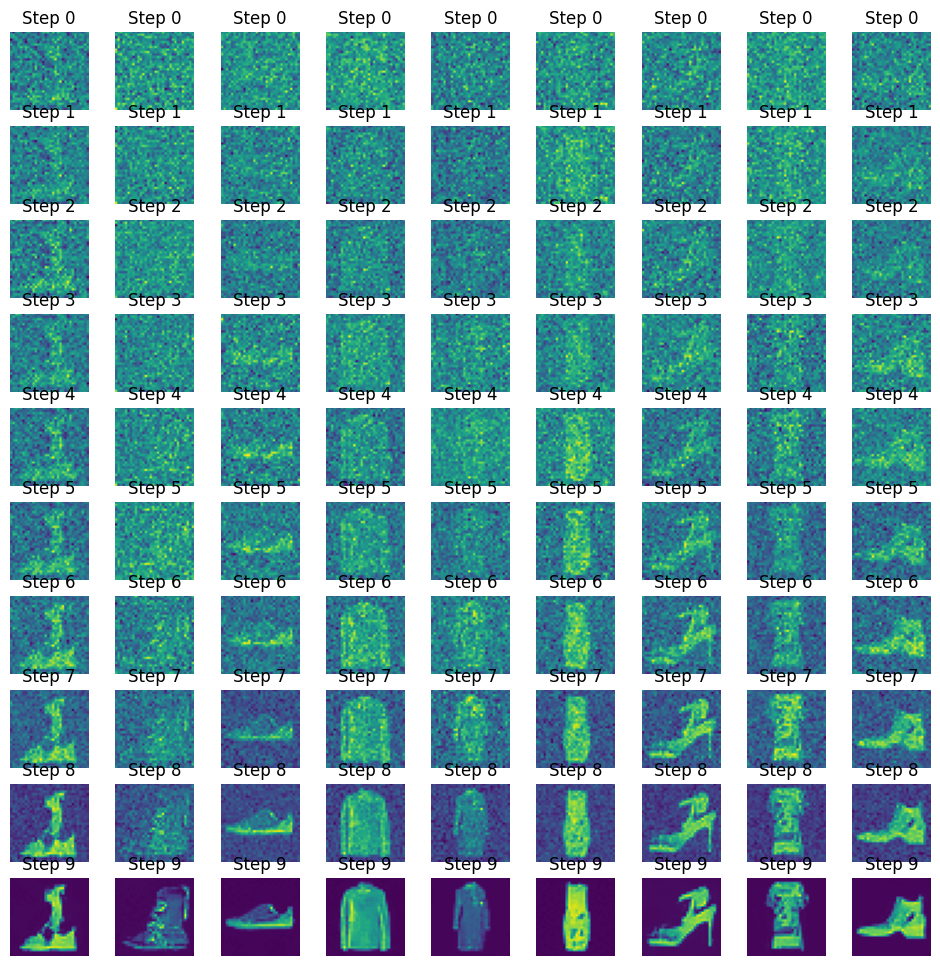

In [33]:
# Отобразим срез после 10
# cur_names = [class_names[label] for label in sample_label]
# print(cur_names)
plot_all_images(tensor_to_images(gen_cond_samples[10:]), row=10, columns=9)

### CFG Работает

# FEEDBACK

## Мне очень нравится, что на лекции в самом конце упомянули про UNet, предварительно потратив час на вывод формул, которые я давным давно уже принял как эвристики (чтобы их действительно понять, нужно устроить полноценный семестровый курс по одной тематике), затем дали домашку на модель, в которой на семинаре вообще ничего не пояснили, и в этот код еще нужно было встроить CFG, который вообще отправили на самостоятельное изучение

### CFG я еще встроил, но из-за того, что предоставленный код модели максимально ужасный - везде, в каждой функции смена размерностей, какие-то непонятные преобразования постоянны, нет строгого формата, понятного для обучения. Как будто новичкам в сфере DFM должны дать максимально крутой репозиторий how-to, нам же дают вот это  https://github.com/awjuliani/pytorch-diffusion.git. Код модели для обучения и для архитектуры смешан в одном модуле pl.Lightning, 

### Про  последнее задание я вообще в шоке. Ноль информации на лекции, дали ссылку на статью, в которой показан алгоритм, который требует целиком изменение всей предоставленной модели из репозитория. В ней все неправильно. Код абсолютно не чистый. Я хочу сделать дз так же, как мне дают материал на лекции, а именно:

### Вот алгоритм того, как легко сделать пункт 4.2 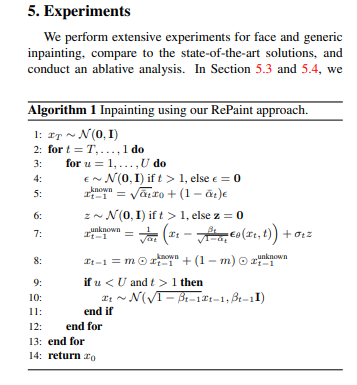

### На этом все. 